## Set Up Notebook

In [13]:
# Load Standard Modules
import pandas as pd 
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from PIL import Image
import zipfile

# Plotting
import matplotlib.pyplot as plt

# Modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense

## Topic

The goal of this project is to get familiar with a GAN model, and create images in the style of Monet. 

## Data Load and Prep

In [2]:
dataset_dir_monet = '/kaggle/input/gan-getting-started/monet_jpg'
dataset_dir_photo = '/kaggle/input/gan-getting-started/photo_jpg'

In [3]:
IMG_SIZE = 256
BATCH_SIZE = 8



# Load images
def load_image(image_file):
    img = tf.io.read_file(image_file)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (img / 127.5) - 1  # Normalize to [-1, 1]
    return img

# Create separate datasets for photos and Monet images
photo_files = tf.data.Dataset.list_files(dataset_dir_photo + '/*.jpg')
monet_files = tf.data.Dataset.list_files(dataset_dir_monet + '/*.jpg')

photo_ds = photo_files.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
monet_ds = monet_files.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# Combine the datasets by zipping them and batching
dataset = tf.data.Dataset.zip((photo_ds, monet_ds))
dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## EDA

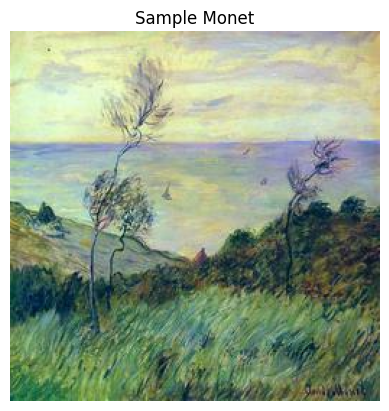

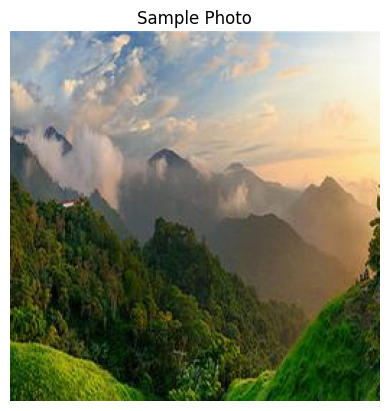

Number of photo images: 7038
Number of Monet images: 300


In [5]:
# Function to display a random image from a directory
def show_random_image(image_dir, title="Image"):
    img_path = os.path.join(image_dir, np.random.choice(os.listdir(image_dir)))
    img = image.load_img(img_path, target_size=(256, 256))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display random images from the photo and Monet datasets
show_random_image(dataset_dir_monet, "Sample Monet")
show_random_image(dataset_dir_photo, "Sample Photo")

# Count of images in each dataset
print(f"Number of photo images: {len(os.listdir(dataset_dir_photo))}")
print(f"Number of Monet images: {len(os.listdir(dataset_dir_monet))}")


## Model

In [8]:
def build_generator():
    model = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=(256, 256, 3)),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        
        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        
        Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        Activation("relu"),
        BatchNormalization(),
        
        Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        Activation("relu"),
        BatchNormalization(),
        
        Conv2D(3, kernel_size=4, padding="same", activation="tanh")
    ])
    return model

# Instantiate generator and print summary
generator = build_generator()
generator.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 128, 128, 128)  │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 256, 256, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 3)    │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 532,355 (2.03 MB)

 Trainable params: 531,587 (2.03 MB)

 Non-trainable params: 768 (3.00 KB)

In [14]:
def build_discriminator():
    model = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=(256, 256, 3)),
        LeakyReLU(alpha=0.2),
        
        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(alpha=0.2),
        BatchNormalization(),
        
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

# Instantiate discriminator and print summary
discriminator = build_discriminator()
discriminator.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       524,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 659,137 (2.51 MB)

 Trainable params: 658,881 (2.51 MB)

 Non-trainable params: 256 (1.00 KB)

In [15]:
# optimizer and discriminator
gen_optimizer = Adam(0.0002, 0.5)
disc_optimizer = Adam(0.0002, 0.5)

# Loss functions
binary_crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def train_step(photo_images, monet_images):
    with tf.GradientTape(persistent=True) as tape:
        # Fake monet
        fake_monet = generator(photo_images, training=True)
        
        # output 
        real_output = discriminator(monet_images, training=True)
        fake_output = discriminator(fake_monet, training=True)
        
        # Calculate loss
        gen_loss = binary_crossentropy(tf.ones_like(fake_output), fake_output)
        disc_loss = binary_crossentropy(tf.ones_like(real_output), real_output) + binary_crossentropy(tf.zeros_like(fake_output), fake_output)

    # Backpropagation and optimization
    grad_gen = tape.gradient(gen_loss, generator.trainable_variables)
    grad_disc = tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Training loop
epochs = 3
for epoch in range(epochs):
    # Generate batches of photos and Monet images
    for photo_batch, monet_batch in dataset: 
        gen_loss, disc_loss = train_step(photo_batch, monet_batch)
    
    print(f"Epoch {epoch+1}/{epochs} - Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}")


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:674: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1/3 - Generator Loss: 7.8758, Discriminator Loss: 1.3565
Epoch 2/3 - Generator Loss: 11.6886, Discriminator Loss: 2.0337
Epoch 3/3 - Generator Loss: 21.5150, Discriminator Loss: 4.8773


## Generate Image and Export

In [16]:
# Define paths and parameters
output_zip_path = 'images.zip'
IMG_SIZE = 256

# Generate and save image
def generate_and_save_image(model, input_image):
    generated_img = model(input_image[tf.newaxis, ...], training=False)[0]
    generated_img = ((generated_img + 1) * 127.5).numpy().astype(np.uint8)  # De-normalize to [0, 255]
    return Image.fromarray(generated_img)

# Open a zip file to write images directly into it
with zipfile.ZipFile(output_zip_path, 'w') as img_zip:
    for i, photo_image in enumerate(photo_ds.take(10000)):  # Adjust `take()` to control number of images
        generated_image = generate_and_save_image(generator, photo_image)
        img_path = f"monet_style_{i + 1}.jpg"
        
        # Save the image to a temp location
        with open(f"/tmp/{img_path}", "wb") as f:
            generated_image.save(f, format="JPEG")

        # Write the temp image to zip and clean up
        img_zip.write(f"/tmp/{img_path}", img_path)
        os.remove(f"/tmp/{img_path}")

print("Image generation and zipping complete. File saved as images.zip")


Image generation and zipping complete. File saved as images.zip
